In [ ]:
#configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#API to fetch the dataset from kaggle
!kaggle competitions download -c playground-series-s4e12

# extracting the compressed Dataset
from zipfile import ZipFile
dataset = 'playground-series-s4e12.zip'
with ZipFile(dataset,'r') as z:
  z.extractall()
  print('Done')

playground-series-s4e12.zip: Skipping, found more recently modified local copy (use --force to force download)
Done


# **Project Overview**

In this project, we analyze Insurance Dataset 📊, which contains important information about individuals, such as their age, sex, smoking status.Main goal is to predict insurance charges based on these features using a regression model 🔮. Specifically, powerful XGBoost algorithm is used to develop a predictive model.

In [ ]:
!pip install optuna
!pip install catboost
# !pip install scikit-learn==1.0.2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

id_col = test['id']
pd.set_option('display.max_columns', None)
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [ ]:
from dateutil.relativedelta import relativedelta
def feature_engineering(df):
  nancols = ['Annual Income','Vehicle Age','Insurance Duration','Credit Score','Number of Dependents','Previous Claims']
  todrop = ['id','Policy Start Date']
  immutecols = ['Number of Dependents','Age','Vehicle Age']
  log_transform_cols = ['Annual Income','Previous Claims']

  for col in nancols:
    col_name = 'Missing'+col
    df[col_name] = df[col].isna().astype(int)

  #Missing Annual Income has significantly low Premium Amount.So, it make sense to fill Nan Values with highest Annual Income
  max_income = df['Annual Income'].max()
  df['Annual Income'] = df['Annual Income'].fillna(-1)

  max_creditscore = df['Credit Score'].max()
  df['Credit Score'] = df['Credit Score'].fillna(max_creditscore)

  max_healthscore = df['Health Score'].max()
  df['Health Score'] = df['Health Score'].fillna(-1)

  #missing claims might mean that person has not made any claim earlier
  df['Insurance Duration'] = df['Insurance Duration'].fillna(-1)
  df['Previous Claims'] = df['Previous Claims'].fillna(0)
  df['Marital Status'] = df['Marital Status'].fillna('Unknown')
  df['Customer Feedback'] = df['Customer Feedback'].fillna('Unknown')
  df['Occupation'] = df['Occupation'].fillna('Unknown')
  #df['Vehicle Age'] = df['Vehicle Age'].fillna(-1)
  # Creating Ratio variables


  policy_start_year = pd.to_datetime(df["Policy Start Date"]).dt.year
  current_year = datetime.now().year
  df['Policy_Age'] = current_year - policy_start_year


  for col in immutecols:
    if df[col].dtype == 'object':  # Check if the column is of object type
        df[col] = df[col].fillna(df[col].mode()[0])  # Fill with the most frequent value
    else:
        df[col] = df[col].fillna(df[col].mean().astype(int))  # Fill with the mean

  for col in todrop:
    if(col in df.columns):
      df = df.drop(col, axis = 1)
  df['Health vs Claims'] = df['Health Score'] / (df['Previous Claims']+1)

  df['Annual Income vs Credit Score'] = df['Annual Income'] / (df['Credit Score']+1)
 # df['Health vs Claims'] = df['Health Score'] / (df['Previous Claims']+1)

  # df_numeric = df.apply(pd.to_numeric, errors='coerce')

# Check for infinite values
  print(df.isna().sum(axis=0))
  # print(np.isinf(df_numeric).sum(axis=0))

  for col in df.columns:
    if df[col].dtype == 'object':
        encoded_df = pd.get_dummies(df[col], prefix=col, drop_first=True).astype(int)
        df = pd.concat([df, encoded_df], axis=1).drop(columns=[col])

  print(df.isna().sum(axis=0))
  return df.astype(int)

In [ ]:
test2 = feature_engineering(test)
train2 = feature_engineering(train)

Age                              0
Gender                           0
Annual Income                    0
Marital Status                   0
Number of Dependents             0
Education Level                  0
Occupation                       0
Health Score                     0
Location                         0
Policy Type                      0
Previous Claims                  0
Vehicle Age                      0
Credit Score                     0
Insurance Duration               0
Customer Feedback                0
Smoking Status                   0
Exercise Frequency               0
Property Type                    0
MissingAnnual Income             0
MissingVehicle Age               0
MissingInsurance Duration        0
MissingCredit Score              0
MissingNumber of Dependents      0
MissingPrevious Claims           0
Policy_Age                       0
Health vs Claims                 0
Annual Income vs Credit Score    0
dtype: int64
Age                              0
Annual 

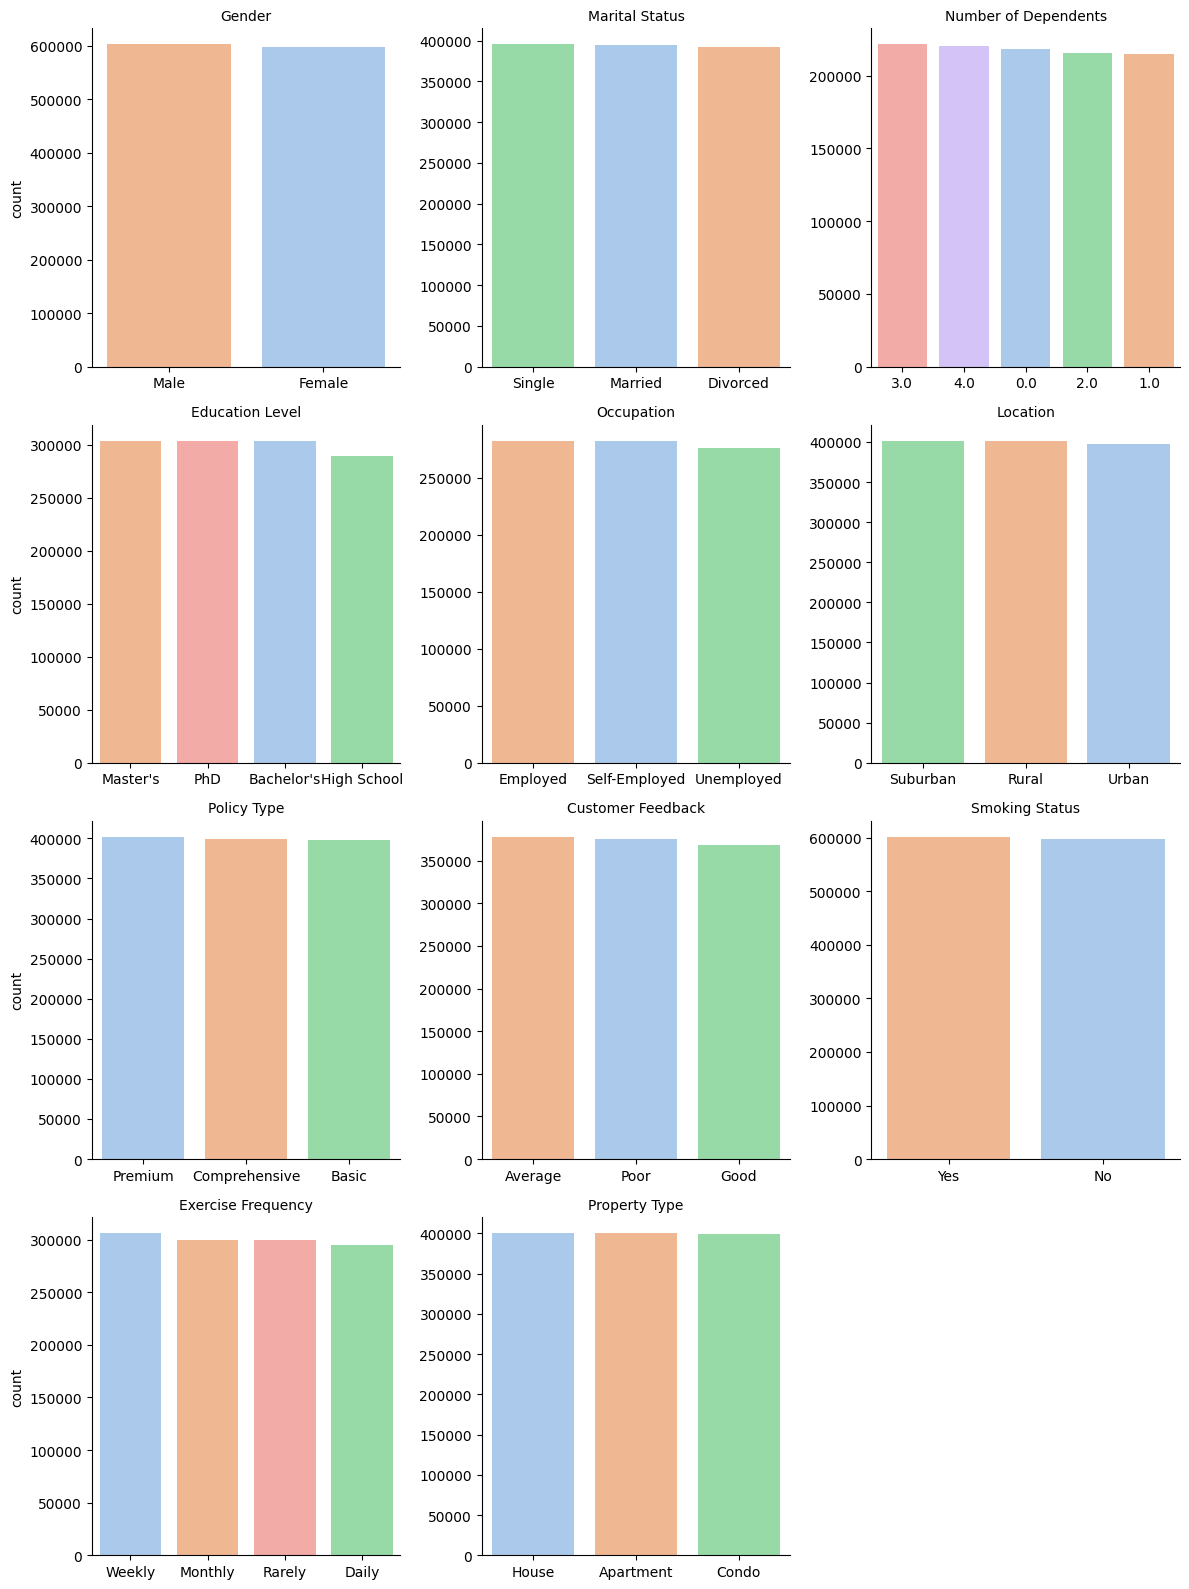

In [ ]:
num_cols = ['Age', 'Annual Income','Health Score','Previous Claims','Vehicle Age', 'Credit Score','Insurance Duration', 'Premium Amount']
melted_cats = train.drop(['id', 'Policy Start Date'] + num_cols, axis = 1).melt(var_name='Feat', value_name='Cat')
fig = sns.FacetGrid(melted_cats, col='Feat', col_wrap=3, height=4, sharex=False, sharey = False)

def plot_feature(data, **kwargs):
    feature = data['Feat'].iloc[0]
    sns.countplot(
        data = data,
        x= 'Cat',
        hue='Cat',
        order=data['Cat'].value_counts().index,
        palette='pastel',
        legend=False,
        **kwargs,
    )

fig.map_dataframe(plot_feature)

fig.set_axis_labels(x_var='', y_var='count')
fig.set_titles('{col_name}')
fig.tight_layout()
plt.show()


Inference: Data in all columns is quite uniformly distributed across different categories in respective columns

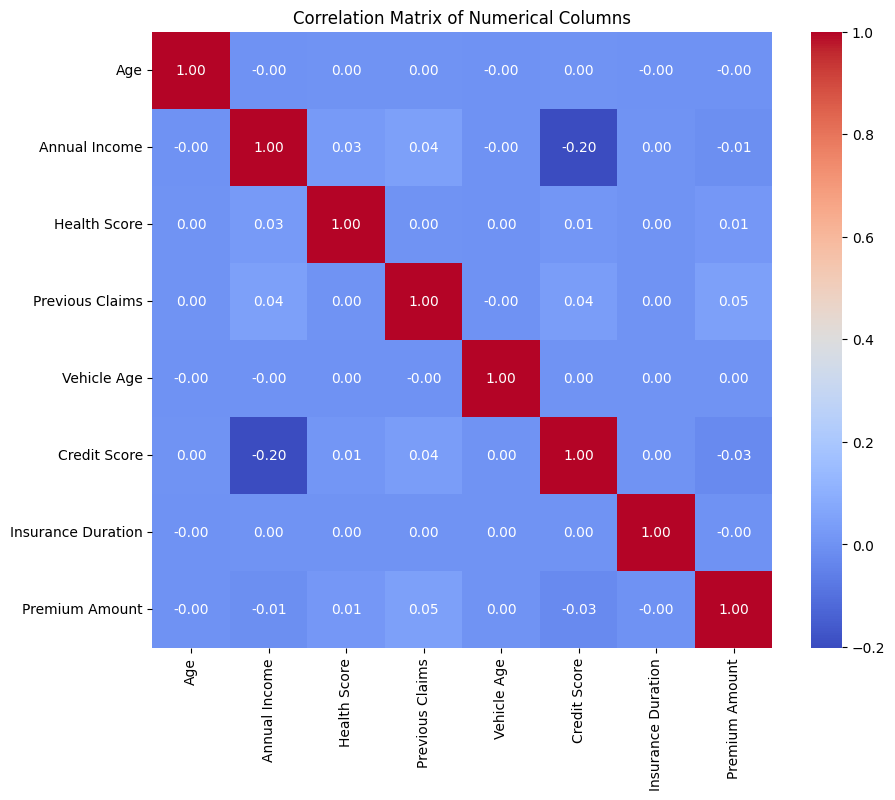

In [ ]:
correlation_matrix = train[num_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

**Inference**: There is near to Zero Correlation among numerical Coumns

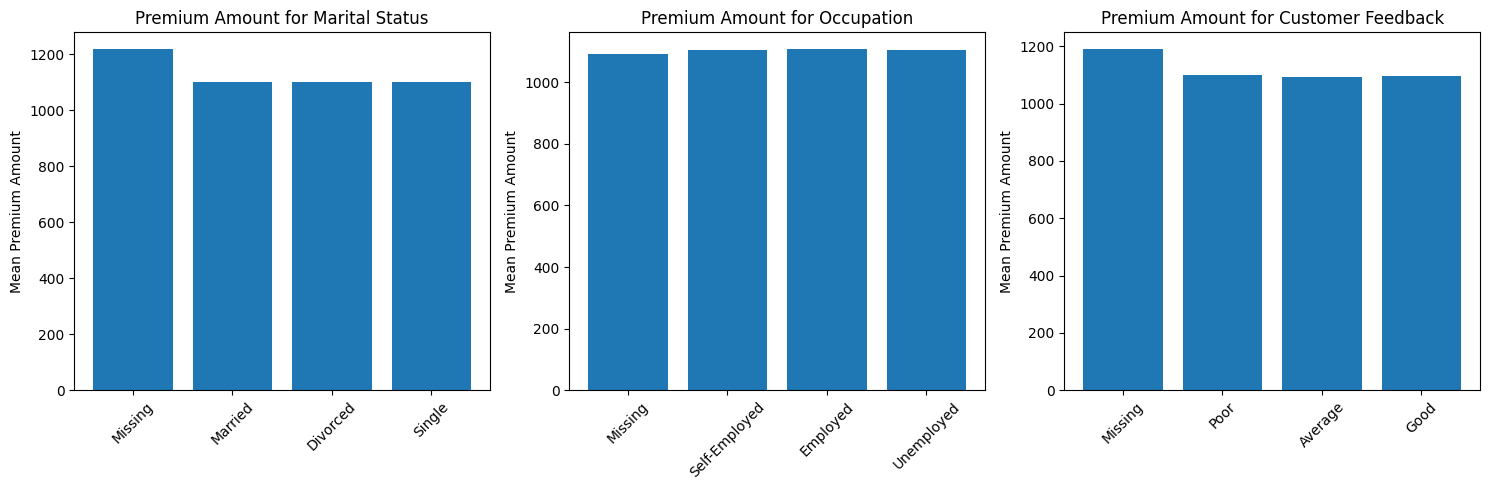

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

columns_with_na = [col for col in train.columns if train[col].isna().sum() > 0 and train[col].dtype == 'object']

n_cols = 3
n_rows = math.ceil(len(columns_with_na) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(columns_with_na):
    ax = axes[idx]

    lst = [train.loc[train[col].isna(), 'Premium Amount'].mean()]
    labels = ['Missing']

    if train[col].dtype == 'object':
        for cat in train[col].dropna().unique():
            lst.append(train[train[col] == cat]['Premium Amount'].mean())
            labels.append(str(cat))
    else:
        lst.append(train.loc[train[col].notna(), 'Premium Amount'].mean())
        labels.append('Not Missing')

    ax.bar(labels, lst)
    ax.set_title(f'Premium Amount for {col}')
    ax.set_ylabel('Mean Premium Amount')
    ax.tick_params(axis='x', rotation=45)

for i in range(len(columns_with_na), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


**Inference** : Avg. Premium Amount with missing values in "Marital Status" and "Customer Feedback" is Significantly higher



In [ ]:
#So,Making Separate Categories for missing Values
train['Marital Status'] = train['Marital Status'].fillna('None')
train['Customer Feedback'] = train['Customer Feedback'].fillna('None')
train['Occupation'] = train['Occupation'].fillna('None')

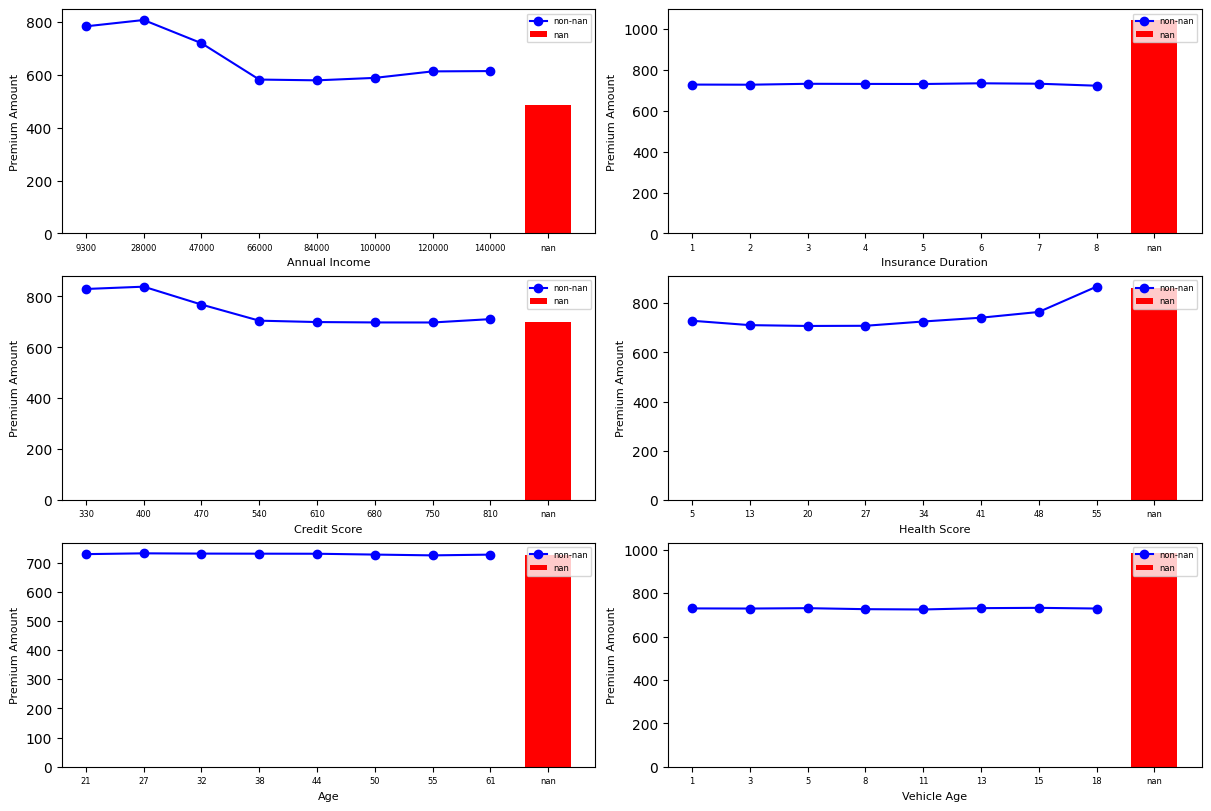

In [ ]:
def Analyse_Nan(col):
    x_col, y_col = col, 'Premium Amount'
    bins = 8
    df = pd.DataFrame({
        x_col: pd.cut(train[x_col], bins),
        y_col: train[y_col]
    })
    s = df.groupby(x_col, observed=True, dropna=False).agg(
        lambda x: np.expm1(np.log1p(x).mean())
    ).reset_index()

    def label(x):
        if isinstance(x, float):
            return x
        x = x.mid
        s = int(np.floor(np.log10(x)))
        return int(round(x, -s + 1))

    return s, x_col, y_col

# Columns to analyze
cols = ['Annual Income', 'Insurance Duration', 'Credit Score', 'Health Score', 'Age', 'Vehicle Age']

# Create subplots
n_cols = 2
n_rows = (len(cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8), constrained_layout=True)

# Flatten axes for easier iteration
axes = axes.flatten()

for i, col in enumerate(cols):
    s, x_col, y_col = Analyse_Nan(col)
    ax = axes[i]

    # Plot non-NaN values
    ax.plot(s[:-1][y_col], 'bo-', label='non-nan')

    # Plot NaN value
    ax.bar(len(s) - 1, s.iloc[-1][y_col], color='red', label='nan')

    # Customize ticks and labels
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels(s[x_col].apply(lambda x: int(round(x.mid, -int(np.floor(np.log10(x.mid))) + 1))), fontsize=6)
    ax.set_xlabel(x_col, fontsize=8)
    ax.set_ylabel(y_col, fontsize=8)
    ax.legend(loc='upper right', fontsize=6)

# Remove unused axes if the number of columns is not even
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

**Inference**: In numercal columns also, it can be clearly observed that avg. Premium Amount with missing values in columns like "Vehicle Age", "Annual Income","Insurance Duration" is sigficantly different.

In [ ]:
#Hence, Creating Columns, depicting Nan/Non-Nan
train['IsMissing_Annual_Income'] = train['Annual Income'].isna().astype(int)
train['IsMissing_Vehicle_Age'] = train['Vehicle Age'].isna().astype(int)
train['IsMissing_Insurance_Duration'] = train['Insurance Duration'].isna().astype(int)
train['IsMissing_Credit_Score'] = train['Credit Score'].isna().astype(int)
train['IsMissing_Number_of_Dependents'] = train['Number of Dependents'].isna().astype(int)
train['IsMissing_Previous_Claims'] = train['Previous Claims'].isna().astype(int)

In [ ]:
#Filling some columns with suitable values to capture meaning out of Nan/Non-Nan values
max_income = train['Annual Income'].max()
train['Annual Income'] = train['Annual Income'].fillna(-1)

max_creditscore = train['Credit Score'].max()
train['Credit Score'] = train['Credit Score'].fillna(max_creditscore)

train['Health Score'] = train['Health Score'].fillna(-1)

train['Insurance Duration'] = train['Insurance Duration'].fillna(-1)

train['Previous Claims'] = train['Previous Claims'].fillna(0)

<ipython-input-14-57749bd64a73>:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


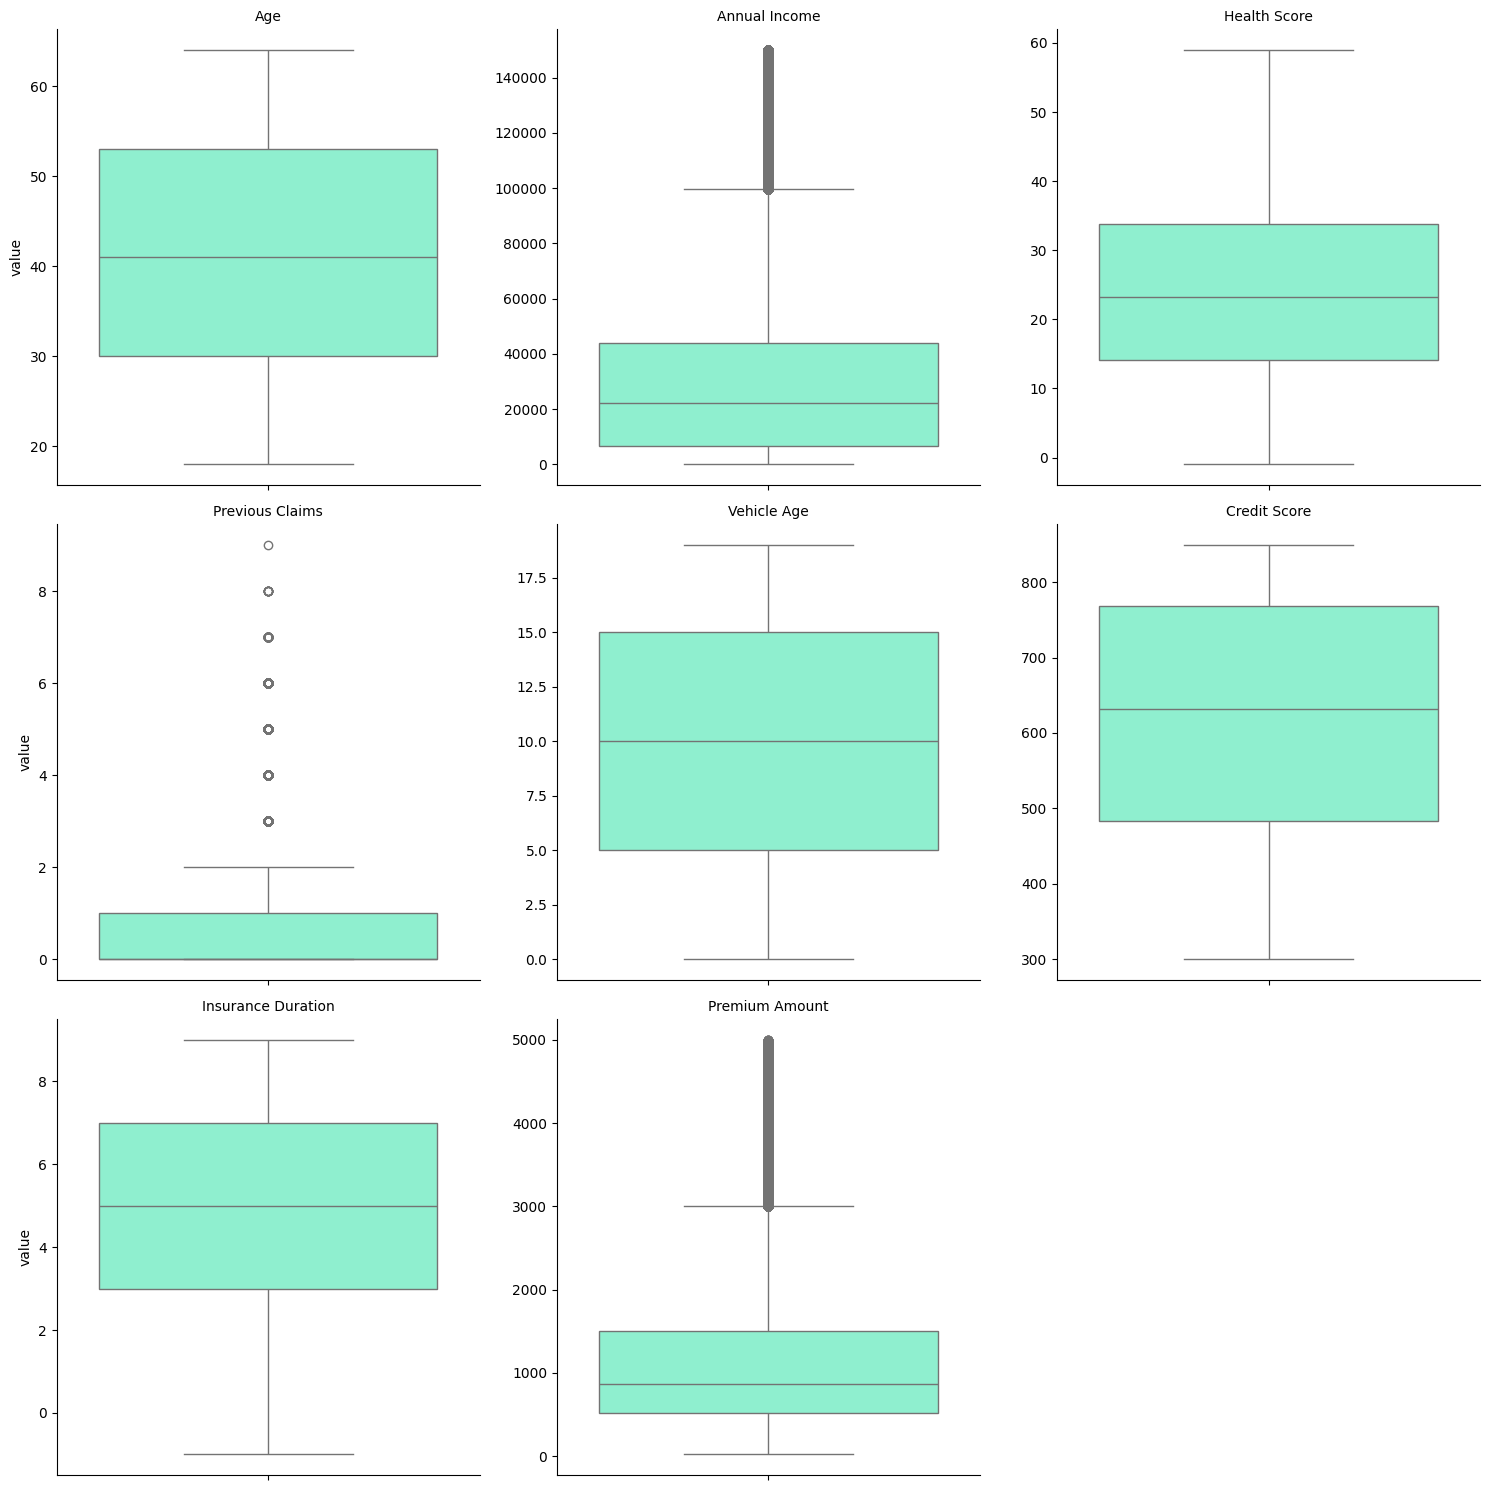

In [ ]:
#Looking for outliers
melted_nums = train[num_cols].melt(var_name='Feat', value_name='Value')

fg = sns.FacetGrid(melted_nums, col='Feat', col_wrap = 3, height = 5, sharey = False, sharex = False)

fg.map_dataframe(sns.boxplot, y = 'Value', color='aquamarine')

fg.set_axis_labels(x_var='', y_var='value')
fg.set_titles("{col_name}")
fig.tight_layout()
plt.show()

**Inference**: only "Annual Income" and "Premium Amount" seems to have outliers

In [ ]:
def non_outliers(feature, df):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)

    iqr = q3-q1
    lower_whisker = q1 - 1.5*(iqr)
    upper_whisker = q3 + 1.5*(iqr)

    return  df[(df[feature] <= upper_whisker) & (df[feature] >= lower_whisker)]

def count_outliers(feature, df):
    newdf = non_outliers(feature, df)
    return (df.shape[0] - newdf.shape[0])

print("No. of Outliers in Annual Income are ",count_outliers('Annual Income', train))
print("No. of Outliers in Premium Amount are ",count_outliers('Premium Amount', train))

No. of Outliers in Annual Income are  67137
No. of Outliers in Premium Amount are  49320


**Inference**: Numbers are significant. It may be that data is skewed

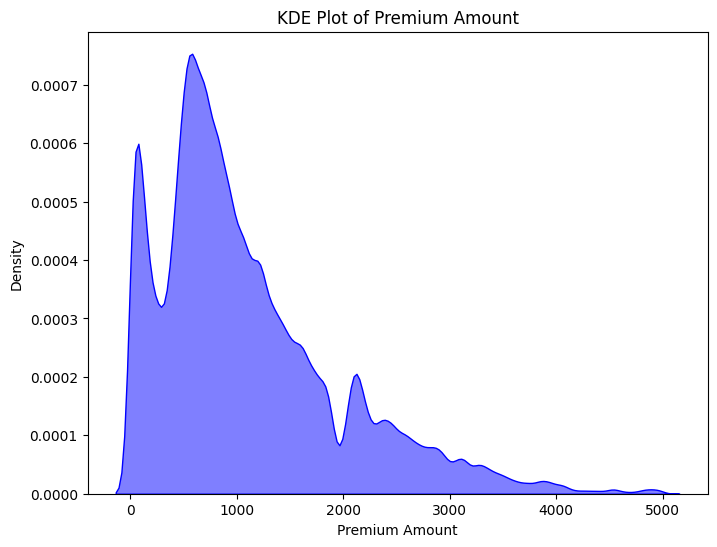

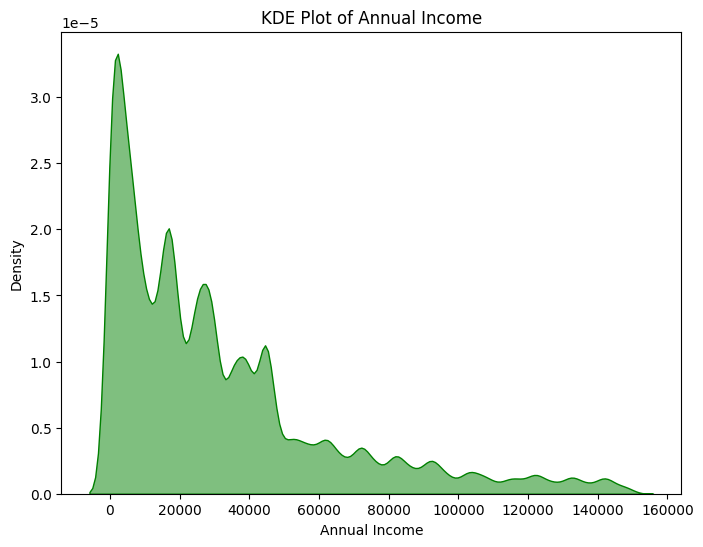

In [ ]:
# KDE Plot for 'Premium Amount'
plt.figure(figsize=(8, 6))
sns.kdeplot(data=train, x='Premium Amount', fill=True, color='blue', alpha=0.5)
plt.title('KDE Plot of Premium Amount')
plt.xlabel('Premium Amount')
plt.ylabel('Density')
plt.show()

# KDE Plot for 'Annual Income'
plt.figure(figsize=(8, 6))
sns.kdeplot(data=train, x='Annual Income', fill=True, color='green', alpha=0.5)
plt.title('KDE Plot of Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Density')
plt.show()

**Inference**:
1.   Yes, Intuition was Correct. Data in "Premium Amount" and "Annual Income" is highly skewed.
2.   So, it will make sense to perform **Log Transformation** on them so that data become more symmetric, stabilizing the variance and eventually, improving the performance of our model.



In [ ]:
#Performing Log Transformation
train['Annual Income'] = np.log1p(train['Annual Income'])
train['Premium Amount'] = (train['Premium Amount'])

In [ ]:
#Extracting Policy Age out of "Policy Start Date"
policy_start_year = pd.to_datetime(train["Policy Start Date"]).dt.year
current_year = datetime.now().year
train['Policy_Age'] = current_year - policy_start_year

#Now Policy Start Date and id columns are useless"
train.drop(["Policy Start Date", "id"], axis = 1, inplace=True)

In [ ]:
#Immuting rest of columns with mean/mode
train['Number of Dependents'] = train['Number of Dependents'].fillna(train['Number of Dependents'].mean().astype(int))
train['Age'] = train['Age'].fillna(train['Age'].mean().astype(int))
train['Vehicle Age'] = train['Vehicle Age'].fillna(train['Vehicle Age'].mean().astype(int))

#Creating Two ratio features
train['Health vs Claims'] = train['Health Score'] / (train['Previous Claims']+1)
train['Annual Income vs Credit Score'] = train['Annual Income'] / (train['Credit Score']+1)

In [ ]:
unique_cnt = []
for col in train.columns:
    if train[col].dtype == 'object':
        unique_cnt.append([col, train[col].nunique()])

unique_cnt_df = pd.DataFrame(unique_cnt, columns=['Column Name', 'Unique Values'])
print(unique_cnt_df)

          Column Name  Unique Values
0              Gender              2
1      Marital Status              4
2     Education Level              4
3          Occupation              4
4            Location              3
5         Policy Type              3
6   Customer Feedback              4
7      Smoking Status              2
8  Exercise Frequency              4
9       Property Type              3


In [ ]:
#using one hot encoding for Categorical Columns
for col in train.columns:
    if train[col].dtype == 'object':
        encoded_df = pd.get_dummies(train[col], prefix=col, drop_first=True).astype(int)
        train = pd.concat([train, encoded_df], axis=1).drop(columns=[col])

train = train.astype(int)
train.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,IsMissing_Annual_Income,IsMissing_Vehicle_Age,IsMissing_Insurance_Duration,IsMissing_Credit_Score,IsMissing_Number_of_Dependents,IsMissing_Previous_Claims,Policy_Age,Health vs Claims,Annual Income vs Credit Score,Gender_Male,Marital Status_Married,Marital Status_None,Marital Status_Single,Education Level_High School,Education Level_Master's,Education Level_PhD,Occupation_None,Occupation_Self-Employed,Occupation_Unemployed,Location_Suburban,Location_Urban,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_None,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,19,10049,1,22,2,17,372,5,2869,0,0,0,0,0,0,1,7,26,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1
1,39,31678,3,15,1,12,694,2,1483,0,0,0,0,0,0,1,7,45,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1
2,23,25602,3,47,1,14,849,3,567,0,0,0,1,0,0,1,23,30,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1
3,21,141855,2,10,1,0,367,1,765,0,0,0,0,0,0,0,5,385,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,21,39651,1,20,0,8,598,4,2022,0,0,0,0,0,0,3,20,66,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1


# **Models' Training and Evaluation**

In [ ]:
train.iloc[100: 115,::]

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,MissingAnnual Income,MissingVehicle Age,MissingInsurance Duration,MissingCredit Score,MissingNumber of Dependents,MissingPrevious Claims,Policy_Age,IsMissing_Annual_Income,IsMissing_Vehicle_Age,IsMissing_Insurance_Duration,IsMissing_Credit_Score,IsMissing_Number_of_Dependents,IsMissing_Previous_Claims,Health vs Claims,Annual Income vs Credit Score,Gender_Male,Marital Status_Married,Marital Status_Single,Marital Status_Unknown,Education Level_High School,Education Level_Master's,Education Level_PhD,Occupation_Self-Employed,Occupation_Unemployed,Occupation_Unknown,Location_Suburban,Location_Urban,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Customer Feedback_Unknown,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
100,51,82546,2,-1,0,3,446,5,8,0,0,0,0,1,1,1,0,0,0,0,0,0,-1,184,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
101,39,-1,0,24,0,7,849,5,5,1,0,0,1,0,1,0,0,0,0,0,0,0,24,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1
102,63,31400,4,15,0,0,593,2,6,0,0,0,0,0,0,4,0,0,0,0,0,0,15,52,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
103,34,4098,1,43,0,5,576,4,6,0,0,0,0,0,0,4,0,0,0,0,0,0,43,7,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
104,51,56415,1,51,0,3,493,2,6,0,0,0,0,0,0,2,0,0,0,0,0,0,51,114,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,1,0
105,44,20705,1,15,4,9,479,9,6,0,0,0,0,0,0,1,0,0,0,0,0,0,3,43,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1
106,32,45301,2,20,0,10,826,5,6,0,0,0,0,0,1,2,0,0,0,0,0,0,20,54,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
107,19,43953,4,31,0,3,849,3,6,0,0,0,1,0,0,4,0,0,0,0,0,0,31,51,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1
108,62,44674,0,40,0,5,332,1,6,0,0,0,0,0,0,4,0,0,0,0,0,0,40,134,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0
109,49,25863,2,-1,1,0,616,5,7,0,0,0,0,0,0,4,0,0,0,0,0,0,0,41,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0


In [ ]:
train2.iloc[100: 115,0:20]

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,MissingAnnual Income,MissingVehicle Age,MissingInsurance Duration,MissingCredit Score,MissingNumber of Dependents,MissingPrevious Claims,Policy_Age,Health vs Claims,Annual Income vs Credit Score,Gender_Male,Marital Status_Married
100,51,82546,2,-1,0,3,446,5,3378,0,0,0,0,1,1,1,-1,184,1,0
101,39,-1,0,24,0,7,849,5,164,1,0,0,1,0,1,0,24,0,0,1
102,63,31400,4,15,0,0,593,2,657,0,0,0,0,0,0,4,15,52,0,1
103,34,4098,1,43,0,5,576,4,954,0,0,0,0,0,0,4,43,7,0,0
104,51,56415,1,51,0,3,493,2,993,0,0,0,0,0,0,2,51,114,1,1
105,44,20705,1,15,4,9,479,9,619,0,0,0,0,0,0,1,3,43,0,0
106,32,45301,2,20,0,10,826,5,607,0,0,0,0,0,1,2,20,54,0,1
107,19,43953,4,31,0,3,849,3,616,0,0,0,1,0,0,4,31,51,1,0
108,62,44674,0,40,0,5,332,1,632,0,0,0,0,0,0,4,40,134,0,0
109,49,25863,2,-1,1,0,616,5,2045,0,0,0,0,0,0,4,0,41,1,0


In [ ]:
#Loading alll required Dependencies
import xgboost as xgb
from catboost import  CatBoostRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor as hgbc
from lightgbm import LGBMRegressor, early_stopping

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#Root mean squared Log Error
def rmsle(y_true_log, y_pred_log):
    return np.sqrt(mean_squared_error(y_true_log, y_pred_log))

#for storing scores of all models
results = []

In [ ]:
# Setting X and Y for model
y = (train['Premium Amount'])
X = train.drop(['Premium Amount'], axis=1)

# Splitting training and testing data
# Train Test Split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

 **XGbRegressor**

In [ ]:
#define the model
xgb_model = xgb.XGBRegressor(   verbosity = 0,
                                objective = 'reg:squarederror',
                                tree_method='hist',
                                n_estimators = 500,
                                max_depth = 9,
                                min_child_weight = 8,
                                learning_rate = 0.01,
                                subsample = 0.8, reg_alpha = 6,
                                reg_lambda = 6,
                                gamma = 0.7
                             )

#Training model
xgb_model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.7, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Evaluating using Cross-validation technique
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_rmsle, fold_rmse, fold_mae, fold_r2 = [], [], [], []
for train_idx, val_idx in kf.split(X, y):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model.fit(
                    X_train_cv, y_train_cv,
                    eval_set=[(X_val_cv, y_val_cv)],
                    verbose=False
                )
    y_pred_log = xgb_model.predict(X_val_cv)
    y_pred = np.expm1(y_pred_log)
    y_val_exp = np.expm1(y_val_cv)

    # Metrics
    fold_rmsle.append(rmsle(y_pred_log, y_val_cv))
    fold_rmse.append(np.sqrt(mean_squared_error(y_val_exp, y_pred)))
    fold_mae.append(mean_absolute_error(y_val_exp, y_pred))
    fold_r2.append(r2_score(y_val_exp, y_pred))

# Compute average metrics
avg_rmsle_xg = np.mean(fold_rmsle)
avg_rmse_xg = np.mean(fold_rmse)
avg_mae_xg = np.mean(fold_mae)
avg_r2_xg = np.mean(fold_r2)

results.append({
          'model_name': 'XGBRegressor',
          'RMSLE_CV': avg_rmsle_xg,
          'RMSE_CV': avg_rmse_xg,
          'MAE_CV': avg_mae_xg,
          'R2_CV': avg_r2_xg
})

**LightGBM**

In [ ]:
#Define the mode
light_model= LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=10, random_state=42)

#train
light_model.fit(x_train, y_train, eval_set=[(x_val, y_val)], callbacks=[early_stopping(stopping_rounds=100)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 38
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.594665
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's l2: 1.09381


LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
              random_state=42)

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_rmsle_lgbm, fold_rmse_lgbm, fold_mae_lgbm, fold_r2_lgbm = [], [], [], []
for train_idx, val_idx in kf.split(X, y):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    light_model.fit(X_train_cv, y_train_cv,
                    eval_set=[(X_val_cv,y_val_cv)],
                    callbacks=[early_stopping(stopping_rounds=100)]
                    )

    y_pred_log = light_model.predict(X_val_cv)
    y_pred = np.expm1(y_pred_log)
    y_val_exp = np.expm1(y_val_cv)

    # Metrics
    fold_rmsle_lgbm.append(rmsle(y_pred_log, y_val_cv))
    fold_rmse_lgbm.append(np.sqrt(mean_squared_error(y_val_exp, y_pred)))
    fold_mae_lgbm.append(mean_absolute_error(y_val_exp, y_pred))
    fold_r2_lgbm.append(r2_score(y_val_exp, y_pred))

# Compute average metrics
avg_rmsle_lgbm = np.mean(fold_rmsle_lgbm)
avg_rmse_lgbm = np.mean(fold_rmse_lgbm)
avg_mae_lgbm = np.mean(fold_mae_lgbm)
avg_r2_lgbm = np.mean(fold_r2_lgbm)

results.append({
          'model_name': 'LGBM',
          'RMSLE_CV': avg_rmsle_lgbm,
          'RMSE_CV': avg_rmse_lgbm,
          'MAE_CV': avg_mae_lgbm,
          'R2_CV': avg_r2_lgbm
})

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.317507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 38
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.594412
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 1.09718
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] N

**CatBoost Regressor**

In [ ]:
#Define the mode
cat_model = CatBoostRegressor()

#train
cat_model.fit(x_train, y_train, verbose = False)

In [ ]:
#Evaluating using Cross-validation technique
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_rmsle_catb, fold_rmse_catb, fold_mae_catb, fold_r2_catb = [], [], [], []
for train_idx, val_idx in kf.split(X, y):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    cat_model.fit(X_train_cv, y_train_cv, verbose = False)

    y_pred_log = cat_model.predict(X_val_cv)
    y_pred = np.expm1(y_pred_log)
    y_val_exp = np.expm1(y_val_cv)

    # Metrics
    fold_rmsle_catb.append(rmsle(y_pred_log, y_val_cv))
    fold_rmse_catb.append(np.sqrt(mean_squared_error(y_val_exp, y_pred)))
    fold_mae_catb.append(mean_absolute_error(y_val_exp, y_pred))
    fold_r2_catb.append(r2_score(y_val_exp, y_pred))

# Compute average metrics
avg_rmsle_catb = np.mean(fold_rmsle_catb)
avg_rmse_catb = np.mean(fold_rmse_catb)
avg_mae_catb = np.mean(fold_mae_catb)
avg_r2_catb = np.mean(fold_r2_catb)

results.append({
          'model_name': 'CatBoost',
          'RMSLE_CV': avg_rmsle_catb,
          'RMSE_CV': avg_rmse_catb,
          'MAE_CV': avg_mae_catb,
          'R2_CV': avg_r2_catb
})

**HistGradientBoostingRegressor**

In [ ]:
#Define the mode
hgbc_model = hgbc(
                  l2_regularization = 2.5,
                  learning_rate = 0.018,
                  max_iter = 502,
                  max_depth = 34,
                  min_samples_leaf = 8,
                  max_leaf_nodes = 68,
                  max_bins = 238,
                  early_stopping = False
              )
#train
hgbc_model.fit(x_train, y_train)

HistGradientBoostingRegressor(early_stopping=False, l2_regularization=2.5,
                              learning_rate=0.018, max_bins=238, max_depth=34,
                              max_iter=502, max_leaf_nodes=68,
                              min_samples_leaf=8)

In [ ]:
#Evaluating using Cross-validation technique
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_rmsle_hgbc, fold_rmse_hgbc, fold_mae_hgbc, fold_r2_hgbc = [], [], [], []
for train_idx, val_idx in kf.split(X, y):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    hgbc_model.fit(X_train_cv, y_train_cv)

    y_pred_log = hgbc_model.predict(X_val_cv)
    y_pred = np.expm1(y_pred_log)
    y_val_exp = np.expm1(y_val_cv)

    # Metrics
    fold_rmsle_hgbc.append(rmsle(y_pred_log, y_val_cv))
    fold_rmse_hgbc.append(np.sqrt(mean_squared_error(y_val_exp, y_pred)))
    fold_mae_hgbc.append(mean_absolute_error(y_val_exp, y_pred))
    fold_r2_hgbc.append(r2_score(y_val_exp, y_pred))

# Compute average metrics
avg_rmsle_hgbc = np.mean(fold_rmsle_hgbc)
avg_rmse_hgbc = np.mean(fold_rmse_hgbc)
avg_mae_hgbc = np.mean(fold_mae_hgbc)
avg_r2_hgbc = np.mean(fold_r2_hgbc)

results.append({
          'model_name': 'HistGradientBoosting',
          'RMSLE_CV': avg_rmsle_hgbc,
          'RMSE_CV': avg_rmse_hgbc,
          'MAE_CV': avg_mae_hgbc,
          'R2_CV': avg_r2_hgbc
})

In [ ]:
#Score Summary of all 4 models
for result_info in results:

  print('----------------------------------------------------')
  print(f"Model: {result_info['model_name']}")
  print(f"RMSLE: {result_info['RMSLE_CV']}")
  print(f"RMSE: {result_info['RMSE_CV']}")
  print(f"MAE: {result_info['MAE_CV']}")
  print(f"R2: {result_info['R2_CV']}")

----------------------------------------------------
Model: XGBRegressor
RMSLE: 1.045726487341923
RMSE: 922.5057564100465
MAE: 621.0919832586416
R2: -0.13739217209895735
----------------------------------------------------
Model: LGBM
RMSLE: 1.0458709420337786
RMSE: 922.725165500216
MAE: 621.3416072334785
R2: -0.13793281157215884
----------------------------------------------------
Model: CatBoost
RMSLE: 1.0471658930868066
RMSE: 924.6130526411163
MAE: 622.1413305125692
R2: -0.14259425024411918
----------------------------------------------------
Model: HistGradientBoosting
RMSLE: 1.045639769835011
RMSE: 922.6646474573159
MAE: 621.1159542433305
R2: -0.1377841158593606


Processing the test data same way as train data

In [ ]:
test['Marital Status'] = test['Marital Status'].fillna('None')
test['Customer Feedback'] = test['Customer Feedback'].fillna('None')
test['Occupation'] = test['Occupation'].fillna('None')

test['IsMissing_Annual_Income'] = test['Annual Income'].isna().astype(int)
test['IsMissing_Vehicle_Age'] = test['Vehicle Age'].isna().astype(int)
test['IsMissing_Insurance_Duration'] = test['Insurance Duration'].isna().astype(int)
test['IsMissing_Credit_Score'] = test['Credit Score'].isna().astype(int)
test['IsMissing_Number_of_Dependents'] = test['Number of Dependents'].isna().astype(int)
test['IsMissing_Previous_Claims'] = test['Previous Claims'].isna().astype(int)

max_income = test['Annual Income'].max()
test['Annual Income'] = test['Annual Income'].fillna(-1)
max_creditscore = test['Credit Score'].max()
test['Credit Score'] = test['Credit Score'].fillna(max_creditscore)
test['Health Score'] = test['Health Score'].fillna(-1)
test['Insurance Duration'] = test['Insurance Duration'].fillna(-1)
test['Previous Claims'] = test['Previous Claims'].fillna(0)

test['Annual Income'] = np.log1p(test['Annual Income'])

policy_start_year = pd.to_datetime(test["Policy Start Date"]).dt.year
current_year = datetime.now().year
test['Policy_Age'] = current_year - policy_start_year

test.drop(["Policy Start Date", "id"], axis = 1, inplace=True)
test['Number of Dependents'] = test['Number of Dependents'].fillna(test['Number of Dependents'].mean().astype(int))
test['Age'] = test['Age'].fillna(test['Age'].mean().astype(int))
test['Vehicle Age'] = test['Vehicle Age'].fillna(test['Vehicle Age'].mean().astype(int))

test['Health vs Claims'] = test['Health Score'] / (test['Previous Claims']+1)
test['Annual Income vs Credit Score'] = test['Annual Income'] / (test['Credit Score']+1)

for col in test.columns:
    if test[col].dtype == 'object':
        encoded_df = pd.get_dummies(test[col], prefix=col, drop_first=True).astype(int)
        test = pd.concat([test, encoded_df], axis=1).drop(columns=[col])

test = test.astype(int)
pd.set_option('display.max_columns', None)
test.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,IsMissing_Annual_Income,IsMissing_Vehicle_Age,IsMissing_Insurance_Duration,IsMissing_Credit_Score,IsMissing_Number_of_Dependents,IsMissing_Previous_Claims,Policy_Age,Health vs Claims,Annual Income vs Credit Score,Gender_Male,Marital Status_Married,Marital Status_None,Marital Status_Single,Education Level_High School,Education Level_Master's,Education Level_PhD,Occupation_None,Occupation_Self-Employed,Occupation_Unemployed,Location_Suburban,Location_Urban,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_None,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,28,2310,4,7,0,19,849,1,0,0,0,1,0,1,1,7,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1
1,31,126031,2,13,0,14,372,8,0,0,0,0,0,1,0,13,337,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0
2,47,17092,0,24,0,16,819,9,0,0,0,0,0,1,1,24,20,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,1,0,0,1,0
3,28,30424,3,5,1,3,770,5,0,0,0,0,0,0,1,2,39,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,1
4,24,10863,2,11,0,14,755,7,0,0,0,0,0,1,3,11,14,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 40 columns):
 #   Column                          Non-Null Count   Dtype
---  ------                          --------------   -----
 0   Age                             800000 non-null  int64
 1   Annual Income                   800000 non-null  int64
 2   Number of Dependents            800000 non-null  int64
 3   Health Score                    800000 non-null  int64
 4   Previous Claims                 800000 non-null  int64
 5   Vehicle Age                     800000 non-null  int64
 6   Credit Score                    800000 non-null  int64
 7   Insurance Duration              800000 non-null  int64
 8   IsMissing_Annual_Income         800000 non-null  int64
 9   IsMissing_Vehicle_Age           800000 non-null  int64
 10  IsMissing_Insurance_Duration    800000 non-null  int64
 11  IsMissing_Credit_Score          800000 non-null  int64
 12  IsMissing_Number_of_Dependents  800000 non-n

**Selecting the best model on the basis of RMSLE and testing on test data**

In [ ]:
#Clearly HistGradientBoostingRegressor has lowest rmsle(= 1.045639769835011)
test_pred = hgbc_model.predict(test)
test_pred = np.expm1(test_pred)

# Submission
submission = pd.DataFrame({'id': id_col, 'Premium Amount': test_pred})
submission.to_csv('submission.csv', index=False)

print("Submission file created.")

Submission file created.


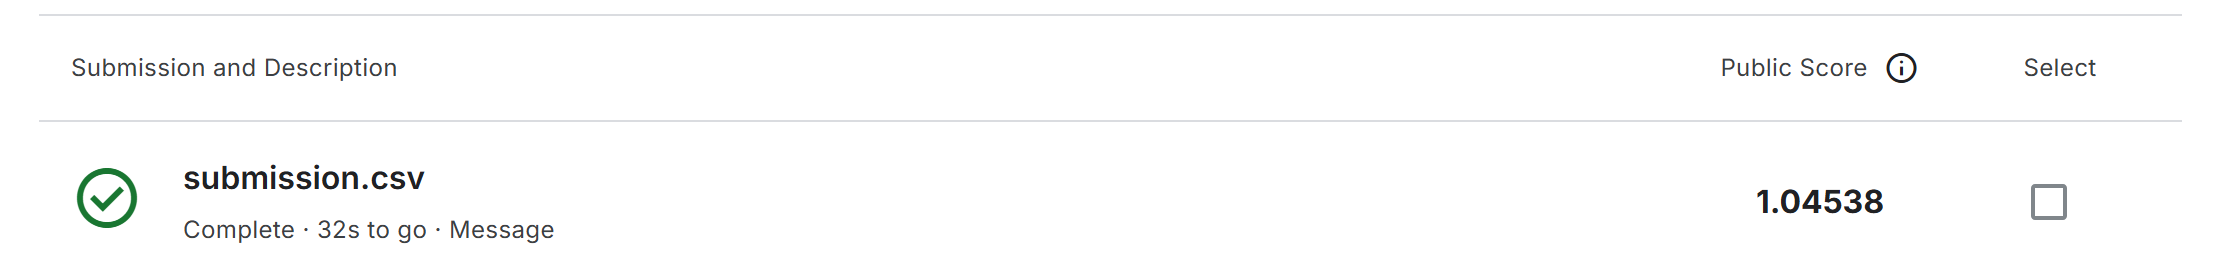

# **Stacking**

1.   By leveraging the strengths of multiple models, stacking can outperform individual models.
2.   Using Ridge Regression as meta model

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
base_estimators = [
    ('model1', cat_model),
    ('model2', light_model),
    ('model3', xgb_model),
    ('model4', hgbc_model)
]

stacking_model = StackingRegressor(estimators=base_estimators, final_estimator=Ridge())
stacking_model.fit(x_train, y_train)

Streaming output truncated to the last 5000 lines.
39:	learn: 1.0488706	total: 4.59s	remaining: 1m 50s
40:	learn: 1.0488338	total: 4.72s	remaining: 1m 50s
41:	learn: 1.0487085	total: 4.83s	remaining: 1m 50s
42:	learn: 1.0486629	total: 4.96s	remaining: 1m 50s
43:	learn: 1.0485796	total: 5.07s	remaining: 1m 50s
44:	learn: 1.0484962	total: 5.19s	remaining: 1m 50s
45:	learn: 1.0484644	total: 5.29s	remaining: 1m 49s
46:	learn: 1.0484127	total: 5.4s	remaining: 1m 49s
47:	learn: 1.0483884	total: 5.51s	remaining: 1m 49s
48:	learn: 1.0483562	total: 5.64s	remaining: 1m 49s
49:	learn: 1.0483248	total: 5.84s	remaining: 1m 51s
50:	learn: 1.0483008	total: 6s	remaining: 1m 51s
51:	learn: 1.0482549	total: 6.2s	remaining: 1m 53s
52:	learn: 1.0482377	total: 6.42s	remaining: 1m 54s
53:	learn: 1.0482029	total: 6.62s	remaining: 1m 55s
54:	learn: 1.0481871	total: 6.83s	remaining: 1m 57s
55:	learn: 1.0481677	total: 7.02s	remaining: 1m 58s
56:	learn: 1.0481518	total: 7.25s	remaining: 1m 59s
57:	learn: 1.04808

StackingRegressor(estimators=[('model1',
                               <catboost.core.CatBoostRegressor object at 0x7c0b3ec82f20>),
                              ('model2',
                               LGBMRegressor(learning_rate=0.01, max_depth=10,
                                             n_estimators=1000,
                                             random_state=42)),
                              ('model3',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_...
                                            max_leaves=None, min_child_weight=8,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('model4',
                               HistGradientBoostingRegressor(early_stopping=False,
                                                             l2_regularization=2.5,
                                                             learning_rate=0.018,
                                                             max_bins=238,
                                                             max_depth=34,
                                                             max_iter=502,
                                                             max_leaf_nodes=68,
                                                             min_samples_leaf=8))],
                  final_estimator=Ridge())

In [ ]:
test_pred = stacking_model.predict(test)
test_pred = np.expm1(test_pred)

# Submission
submission = pd.DataFrame({'id': id_col, 'Premium Amount': test_pred})
submission.to_csv('submission.csv', index=False)

print("Submission file created.")

Submission file created.


In [ ]:
!kaggle competitions submit -c playground-series-s4e12 -f submission.csv -m "Message"

100% 19.8M/19.8M [00:00<00:00, 37.6MB/s]
Successfully submitted to Regression with an Insurance Dataset

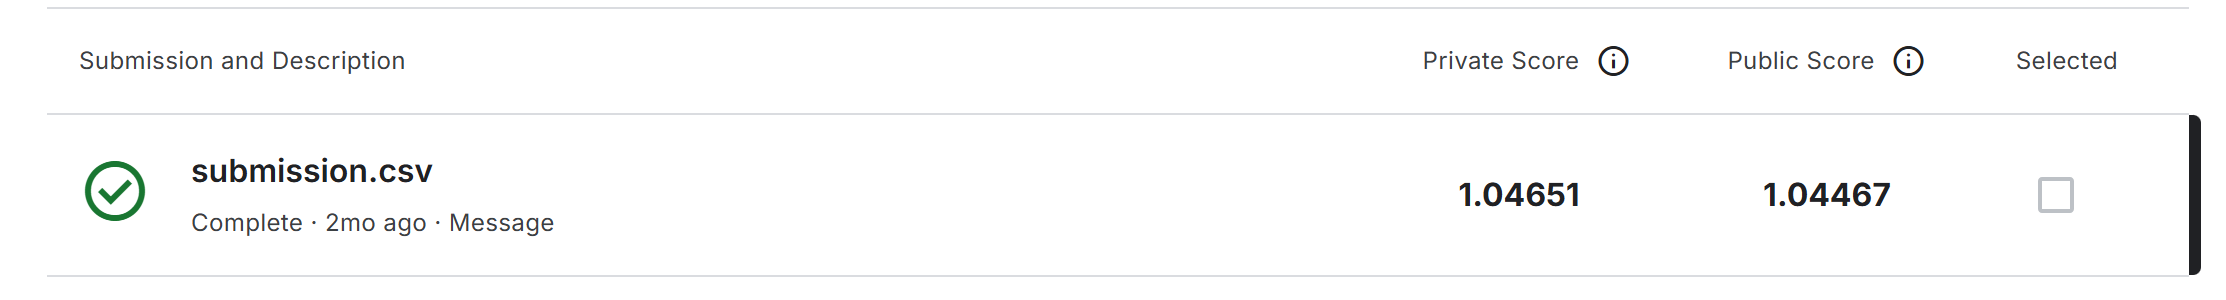

# **End Of Project**
This marks the end of this project. A small summary of the process we went through:

--> Imported and cleaned dataset.

--> Did the Data Analysis, Cleaning and Preprocessing of the data available to check skewness of data, ultimately applying log tranformation to fix this.

--> Did Data Visualization of Nan and Non-Nan values by Plotting Graphs.

--> Used Multiple Regression Models as base models,first on our dataset and thereafter used ensemble model technique(or stacking) using Ridge Regression as meta model. This model did a much better job and had an RMSLE score of 1.04651

--> Used Train_Test_Split to cross validate. We also used KFolds to get rid of any inaccuracies in obtaining Evaluation scores.